In [7]:
# Import library
import pandas  as pd #Data manipulation
import numpy as np #Data manipulation
import matplotlib.pyplot as plt # Visualization
import seaborn as sns #Visualization

# Define figure params
plt.rcParams['figure.figsize'] = [8,5]
plt.rcParams['font.size'] =14
plt.rcParams['font.weight']= 'bold'
plt.style.use('seaborn-whitegrid')

In [2]:
path = 'C:/Users/czlni/Desktop/'
df_Sklearn = pd.read_csv(path+'df_Sklearn.csv')
df_encode = pd.read_csv(path+'df_encode.csv')

In [3]:
Y=df_encode[['log_price', 'price']]
X=df_encode.drop(columns=['log_price','price'])

It is not required that the regression tree target variable be normally distributed. However, given that we observe that multiple price values are extremely high, it might be helpful to predict the log of price. These large values might strongly influence the loss function. 

Below are the models with the log of price.

In [4]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(X,Y,train_size=0.8,random_state=42)

print(f"No. of training examples: {x_train.shape[0]}")
print(f"No. of testing examples: {x_test.shape[0]}")

No. of training examples: 8000
No. of testing examples: 2000


Fit initial model:

In [8]:
from sklearn.ensemble import RandomForestRegressor

Min_samples_per_leaf = 10
Max_features = None # "sqrt","log2", or int
Num_trees = 500
# create the model
model_rf = RandomForestRegressor(n_estimators=Num_trees, min_samples_leaf=Min_samples_per_leaf, max_features=Max_features, \
                                 bootstrap=True, oob_score=True, random_state=100)

# fitting the model
model_rf.fit(x_train, y_train['log_price']) 

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=10, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=500,
                      n_jobs=None, oob_score=True, random_state=100, verbose=0,
                      warm_start=False)

In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
scores_initial = cross_val_score(model_rf,x_train,y_train['log_price'],cv=10,scoring='neg_mean_absolute_error')

In [11]:
scores_initial

array([-0.22213964, -0.23172601, -0.22386654, -0.21520403, -0.21812942,
       -0.23157981, -0.21276785, -0.22924072, -0.22923566, -0.22284532])

In [12]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score

# get original predictions
pred_train_rf= model_rf.predict(x_train)

print("Training Evaluation on Log of Price")
print("Mean Square Error",np.sqrt(mean_squared_error(y_train['log_price'],pred_train_rf)))
print("R2 Score",r2_score(y_train['log_price'], pred_train_rf))

print("Testing Evaluation on ")
# testing predictions
# log of price
pred_test_rf_log = model_rf.predict(x_test)
#convert back to level price
pred_test_rf = np.exp(pred_test_rf_log)
print("Mean Square Error on original price",np.sqrt(mean_squared_error(y_test['price'],pred_test_rf)))
print("R2 Score on original price",r2_score(y_test['price'], pred_test_rf))

Training Evaluation on Log of Price
Mean Square Error 0.26808181414786536
R2 Score 0.7614726791224771
Testing Evaluation on 
Mean Square Error on original price 204.2749243116262
R2 Score on original price 0.6190991976887608


The model performance has improved significantly by transforming the price variable. The model output is log of price. A transformation converting log of the price back to the original price is conducted. In terms of MSE and R-square score, this model's performance is much better than the model in Note 3("3 Random Forest on Original Price"). In the test set, MSE on the original price is 204, and the R-square score is 62%, while with the model in Note 3,  MSE on the actual price is 255, and the R-square score is 40%. 

Below are result visualizations: 

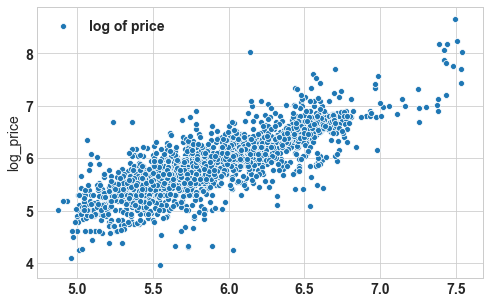

In [13]:
sns.scatterplot(x=pred_test_rf_log,
                y=y_test['log_price'],
                label='log of price')
#plt.legend()

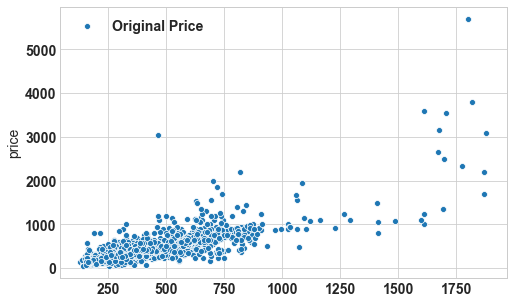

In [14]:
sns.scatterplot(x=pred_test_rf,
                y=y_test['price'],
                label='Original Price')
#plt.legend()

The scatter plot predicted value vs. actual value shows a much better fit in the test set as the predicted values are closer to actual values. However, we can see that the model underpredicts many extreme values.

Below are parameters tuning to improve the model performance.

In [15]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

def rfr_model(X, y):
# Perform Grid-Search
    gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'max_depth': range(3,30,3),
            'n_estimators': (10,50,100, 500,1000),
            'min_samples_leaf': range(2,7),
            'max_features':["sqrt","log2",None]
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
    
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    
    return best_params

In [16]:
best_param=rfr_model(x_train, y_train['log_price'])

In [17]:
best_param

{'max_depth': 15,
 'max_features': None,
 'min_samples_leaf': 2,
 'n_estimators': 500}

In [18]:
# the tree using the restuls from grid search
rfr = RandomForestRegressor(max_depth=best_param["max_depth"], n_estimators=best_param["n_estimators"], \
                            min_samples_leaf=best_param['min_samples_leaf'],max_features=best_param['max_features'], \
                            bootstrap=True, oob_score=True, random_state=100)  

In [19]:
rfr.fit(x_train, y_train['log_price'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=500,
                      n_jobs=None, oob_score=True, random_state=100, verbose=0,
                      warm_start=False)

In [20]:
scores = cross_val_score(rfr,x_train,y_train['log_price'],cv=10,scoring='neg_mean_absolute_error')

In [23]:
scores

array([-0.21478738, -0.22236843, -0.21697972, -0.2115289 , -0.21120646,
       -0.2251667 , -0.20754258, -0.22321116, -0.22532664, -0.21481417])

In [21]:
# get original predictions
pred_train_rf= rfr.predict(x_train)

print("Training Evaluation on Log of Price")
print("Mean Square Error",np.sqrt(mean_squared_error(y_train['log_price'],pred_train_rf)))
print("R2 Score",r2_score(y_train['log_price'], pred_train_rf))

Training Evaluation on Log of Price
Mean Square Error 0.20680380750990973
R2 Score 0.8580548743873211


In [24]:
print("Testing Evaluation")
# testing predictions
# log of price
pred_test_rf_log = rfr.predict(x_test)
#convert back to level price
pred_test_rf = np.exp(pred_test_rf_log)
print("Mean Square Error on original price",np.sqrt(mean_squared_error(y_test['price'],pred_test_rf)))
print("R2 Scoreon original price",r2_score(y_test['price'], pred_test_rf))

Testing Evaluation
Mean Square Error on original price 199.06654019356606
R2 Scoreon original price 0.6382751812057201


After parameter turning, the in-sample r-square increased from 77% to 90%. However, the R-square on the original price only increases from 62% to 64% in the test sample. The improvement is not significant by turning parameters of the random forest model. 

Below shows the importance of vairables in the final model after parameter turing:

In [32]:
rfr.feature_importances_

array([9.06513538e-03, 4.75731964e-03, 3.28852951e-03, 1.97421349e-03,
       5.69527683e-03, 2.29864819e-03, 2.32100822e-03, 2.13926930e-03,
       1.40242238e-03, 0.00000000e+00, 0.00000000e+00, 1.49182761e-03,
       1.19100576e-03, 6.37394771e-04, 1.76668839e-03, 2.74227734e-04,
       9.28492141e-03, 3.34126688e-04, 7.09393654e-04, 2.77650743e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.98405966e-04, 0.00000000e+00, 5.36784193e-04,
       4.86633989e-04, 1.12487766e-03, 1.26927514e-03, 7.15103151e-04,
       2.78097247e-04, 5.04937762e-05, 7.11527368e-04, 3.42421546e-04,
       1.57976727e-03, 9.98255690e-04, 1.30884384e-03, 7.91192031e-05,
       3.09215607e-04, 1.02949880e-04, 4.62024417e-04, 5.25761668e-04,
       8.86628663e-05, 3.68715652e-04, 1.28265537e-04, 8.14979607e-05,
       1.18592003e-04, 3.32971299e-04, 5.47513980e-04, 5.45356222e-05,
       6.08091127e-04, 3.31374000e-04, 2.78701371e-03, 4.15079411e-04,
      

<BarContainer object of 128 artists>

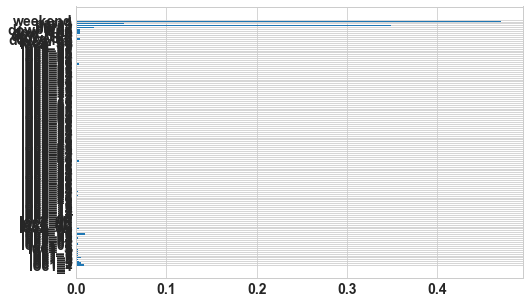

In [29]:
plt.barh(np.array(x_train.columns), rfr.feature_importances_)

Text(0.5, 0, 'Random Forest Feature Importance')

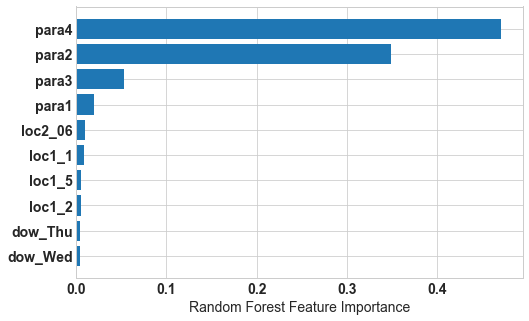

In [62]:
# only outoup top 10 variables for information 
sorted_idx = rfr.feature_importances_.argsort()
plt.barh(np.array(x_train.columns)[sorted_idx][-10:], rfr.feature_importances_[sorted_idx][-10:])
plt.xlabel("Random Forest Feature Importance")

# Conclusion 

**1. Given the non-linear relationships between price and other regressors, non-linear models have better prediction performance than linear models.**

**2. The final random forest model after parameter tuning has a 64% R-square score. The target variable is transformed into log of price. The top variables based on contributions are Para 4,2,3,1, 4 location-related dummy variables, and then dummy variables indicate Thursday and Wednesday.**

**3. Improvement considered:**

*  More information on regressors regarding definition and intuition on price will be helpful. More variables could potentially be created based on intuition.
* Other nonlinear models may consider improving the prediction performance.
